In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch 
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

from moa.model import DenseNet, Model, DenseBlock
from moa.preprocess import cp_mapping, cp_filter,robust_scaling,standard_scaling,rankgauss, fe_stats, c_squared, fe_pca, variance_thresh

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

data_dir = './DATA/lish-moa/'
SEED = 123
np.random.seed(SEED)

## Load data set

In [91]:
X = pd.read_csv(data_dir+'train_features.csv', index_col='sig_id')
y = pd.read_csv(data_dir+'train_targets_scored.csv', index_col='sig_id')
X_sub = pd.read_csv(data_dir+'test_features.csv', index_col='sig_id')

## Preprocess

In [99]:
# 2. preprocessing
X1, X1_sub = cp_mapping(X, X_sub); y1=y.copy()
X1, y1, X1_sub = cp_filter(X1, y1, X1_sub)
X1, X1_sub = fe_stats(X1, X1_sub)
X1, X1_sub = c_squared(X1, X1_sub)
X1, X1_sub = robust_scaling(X1, X1_sub)
X1, X1_sub = fe_pca(X1, X1_sub, n_components_g = 70, n_components_c = 10, SEED = 233)
X1, X1_sub = variance_thresh(X1, X1_sub, 0.8, 2)

In [ ]:
print(X1.shape)
print(X1_sub.shape)

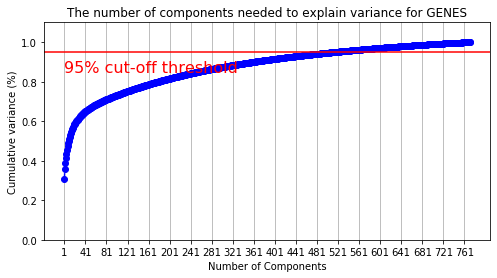

In [96]:
# number of PCA components for GENES
GENES = [col for col in X1.columns if col.startswith('g-')]
    
data = pd.concat([X1[GENES], X1_sub[GENES]])

pca = PCA().fit(data)
plt.rcParams["figure.figsize"] = (8, 4)
fig, ax = plt.subplots()
x = np.arange(1, 1+len(GENES), step=1)
y_tmp = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0., 1.1)
plt.plot(x, y_tmp, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+len(GENES), step=40))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance for GENES')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, "95% cut-off threshold", color='red', fontsize=16)
ax.grid(axis='x')

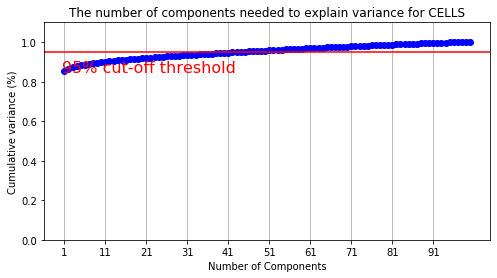

In [101]:
# number of PCA components for CELLS
CELLS = [col for col in X1.columns if col.startswith('c-')]
data = pd.concat([X1[CELLS], X1_sub[CELLS]])

pca = PCA().fit(data)
plt.rcParams["figure.figsize"] = (8, 4)
fig, ax = plt.subplots()
x = np.arange(1, 1+len(CELLS), step=1)
y_tmp = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0., 1.1)
plt.plot(x, y_tmp, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+len(CELLS), step=10))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance for CELLS')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, "95% cut-off threshold", color='red', fontsize=16)
ax.grid(axis='x')

## Training

In [6]:
n_SEED = 2
n_fold = 5
torch.manual_seed(42)
def objective(params):
    epoch, lr, batch_size, L1, L2 = int(params['epoch']), params['lr'],int(params['batch_size']),params['L1'],params['L2']
    train_loss = []
    test_loss = []
    for i_SEED in range(n_SEED):
        SEED = 65 + 123*i_SEED
        kfold = KFold(n_splits=n_fold, shuffle=True, random_state=SEED)
        for n, (train_idx, test_idx) in enumerate(kfold.split(X1)):
            X_train = X1.iloc[train_idx].values
            X_test = X1.iloc[test_idx].values
            y_train = y1.iloc[train_idx].values
            y_test = y1.iloc[test_idx].values
            
            params_net = {'input_size': X1.shape[1],
                     'hidden_size': hidden_size, # 
                     'output_size': y1.shape[1],
                     'dropout': dropout} # 长度比hidden_size长度多1
            params_fit = {'X':X_train,
                         'y': y_train,
                         'epoch': epoch,
                         'lr': lr, 
                         'batch_size':batch_size, # 64, 128
                         'L1': L1,
                         'L2': L2,
                         'pos_weight':1,
                         'patience':5,
                         'verbose':False}
            net = DenseNet(**params_net)
            model = Model(net)
            model.fit(**params_fit)
            y_train_pred = model.predict_proba(X_train)
            y_test_pred = model.predict_proba(X_test)
            train_loss.append(log_loss(y_train.ravel(), y_train_pred.ravel()))
            test_loss.append(log_loss(y_test.ravel(), y_test_pred.ravel()))
            print(f"SEED {i_SEED+1}/{n_SEED}, KFOLD {n+1}/{n_fold} completed.")
    train_loss_avg = np.average(np.array(train_loss))
    test_loss_avg = np.average(np.array(test_loss))
    print('Training loss : ', train_loss_avg)
    print('Validation loss : ', test_loss_avg)
    writer.writerow([epoch, lr, batch_size, L1, L2, train_loss_avg, test_loss_avg])
    return test_loss_avg

Epoch [1, 40] : train loss 0.664790689945221
Epoch [1, 80] : train loss 0.3260881006717682
Epoch [1, 120] : train loss 0.11969415843486786
Validation loss decreased (inf --> 0.094926).  Saving model ...
Epoch [2, 40] : train loss 0.07218655198812485
Epoch [2, 80] : train loss 0.06190790235996246
Epoch [2, 120] : train loss 0.05546260625123978
Validation loss decreased (0.094926 --> 0.055502).  Saving model ...
Epoch [3, 40] : train loss 0.052423469722270966
Epoch [3, 80] : train loss 0.04857975244522095
Epoch [3, 120] : train loss 0.043507568538188934
Validation loss decreased (0.055502 --> 0.045653).  Saving model ...
Epoch [4, 40] : train loss 0.04390174150466919
Epoch [4, 80] : train loss 0.04150206595659256
Epoch [4, 120] : train loss 0.038098178803920746
Validation loss decreased (0.045653 --> 0.040559).  Saving model ...
Epoch [5, 40] : train loss 0.03927799314260483
Epoch [5, 80] : train loss 0.03765852004289627
Epoch [5, 120] : train loss 0.03522629290819168
Validation loss dec

In [ ]:
# hidden_size = [2048, 2048]
# dropout = [0, 0.35, 0.2]

# params = {'epoch': 125,
#           'lr': 0.0005302154778849957, # 1e-4 ~ 1e-3
#           'batch_size':85, # 64, 128, 256, 512
#           'L1': 1e-5,
#           'L2': 5e-5
# }
# filename = 'Manual.csv'
# if not os.path.exists(filename):
#     with open(filename, 'w') as file:
#         writer = csv.writer(file)
#         writer.writerow(['NN hyperparamerter tuning'])
#         writer.writerow(['hidden_size', 'dropout'])
#         writer.writerow(['epoch', 'lr', 'batch_size', 'L1', 'L2', 'Train_loss', 'Val_loss'])

# with open(filename, 'a') as file:
#     writer = csv.writer(file)
#     writer.writerow([hidden_size, dropout])
#     objective(params);

EarlyStopping counter: 1 out of 5


In [3]:
# Import predictors from public kernel
import json
json_file_path = 'main_predictors.json'
with open(json_file_path, 'r') as j:
    predictors = json.loads(j.read())
    predictors = predictors['start_predictors']

In [4]:
len(predictors)

447